# CinC 2021: Recurrence analysis and PS detection

This notebook is made to illustrate the code that led to the following  CinC publication: *Name*

This is a single example using one of the models, the same used for the figure in the paper. The loops used for generating the results for all of the simulations are in the script "PSPresenceAndRecurrenceRate.py" in the "psdetection" folder.

Codes for all of the figures in the paper and some others I used for presentations are in the "CinCVisualizationAndStatistics.py" script in the "scripts" folder

## Loading libraries and defining functions

In [1]:
# Python libraries
import os,sys
import numpy as np
import pandas as pd
import multiprocessing as mp
from itertools import repeat
try:
    import pickle5 as pickle
except:
    import pickle
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# My libraries
upperDir = os.path.dirname(os.getcwd())
sys.path.append(os.path.join(upperDir,'aux-functions'))
sys.path.append(os.path.join(upperDir,'recurrence'))
sys.path.append(os.path.join(upperDir,'psdetection'))

import pslibrary as psl
from RecurrenceComputation import RecurrenceComputation

In [2]:
# New functions for convenient loops
def PSDFLoop(DF):
    return np.min(DF,axis=0)

def MakeRPs(DM,estimatedAFCL,tBegin,tEnd,sampleShift=5,threshold= 0.15):
    RP, recurrenceTime, recurrenceThreshold, _ = \
                recComp.ComputeRecurrencePlot(DM, 1000,
                                              estimatedAFCL,recurrenceThreshold= threshold)          
    RP  = RP[tBegin//sampleShift:tEnd//sampleShift,:][:,tBegin//sampleShift:tEnd//sampleShift]
    return RP,recurrenceTime

## Configuration of the recurrence analysis

In [3]:
# Recurrence analysis
SampleShift = 5
recComp = RecurrenceComputation()
recComp.SampleShift = SampleShift
recComp.TheilerAFCLNumber = 0.5
recComp.ExpectedAFRecurrenceRate = 1 # Only used if no threshold is passed

# Paths
PSPATH =    'D:\\vgmar\\model_data\\exp906\\pstracker\\Control\\Filtered'
RECPATH =   'D:\\vgmar\\model_data\\exp906\\recurrence\\Control'
SAVEPATH =  'D:\\vgmar\\model_data\\exp906\\CinC'
FILENAME =  'PSPresenceAndRQA_16Positions.pkl'

# Convenience Variables
# The time intervals were defined to encompass Fig. 3 of the article
AFCL_TH = 5 # AFCLs
tBegin = 9000 #ms
tEnd = 15000  #ms
fs = 1000 # Hz
NProcesses = 2  # for parallel loops
ArrayRadius = 7 # Size of measurement array
NElectrodes = 16# Number of catheter positions

experiment = 'exp906c82'

## Load recurrence matrices and PS dataframes

Both of these informations have to be calculated previously by the following scripts:
- ~/scripts/CalcSaveDistanceMatrices.py
- ~/jupyter/Distance along shell (PSs x Catheters)

In [4]:
# Open previously generated distance matrices and estimated AFCLs
# This is generate with the code: CalcSaveDistanceMatrices.py
with open(os.path.join(RECPATH,experiment+'_RecurrenceAnalyses.pkl'),'rb') as output:
    DistanceMatrices =  pickle.load(output)
    EstimatedAFCLs =  pickle.load(output)
meanAFCL = np.mean([EstimatedAFCLs[key] for key in EstimatedAFCLs])
# Open DataFrame with all PS data (>100ms) and distance to catheter centers
# This is generated with the code: Distance along shell (PSs x Catheters)
InputDF = pd.read_csv(os.path.join(PSPATH,experiment+'_PSPositionsAndDistances.csv'))
InputDF = InputDF[InputDF.columns[1:]]
# Limit DF to time boundaries
InputDF = InputDF.loc[(InputDF['t']>=tBegin) & (InputDF['t']<tEnd)]  
InputDF['t'] = InputDF['t']-tBegin # To avoid problems with indexing

## Calculate the lowest distance between ANY PS and the catheter centers

If the closest PS is inside the catheter radius, then we mark it as a "PS presence"

In [5]:
PSUnder = np.zeros((tEnd-tBegin,16))

# This part of the code works originally in parallel, I have adapted it to run in Windows and Jupyter
minDF = np.empty(shape=(0,len(InputDF.columns)))

for t in np.unique(InputDF['t']):
    DF = np.asarray(InputDF.loc[InputDF['t']==t,:])
    minDF = np.append(minDF,PSDFLoop(DF).reshape(1,-1),axis=0)

    
minDF = pd.DataFrame(minDF,columns = InputDF.columns)
times = np.unique(InputDF['t']).astype(int) # Maybe something went wrong in isolated time steps
minDF = minDF[minDF.columns[5:]] # Only the distances, ignoring specific positions

# Check if any PSs are within ArrayRadius
PSUnder[times,:] = np.asarray(minDF<=ArrayRadius)
WholePercentages =np.sum(PSUnder,axis=0)/PSUnder.shape[0]*100 # % with PSs for the thole RP

print('The whole percentage of the recordings are the following:\n')
for key,percentage in zip(DistanceMatrices.keys(),WholePercentages): print('%s : %0.2f%%'%(key,percentage))

The whole percentage of the recordings are the following:

RPV : 49.83%
LPV : 0.00%
PLA : 62.13%
ILA_1 : 9.13%
ILA_2 : 0.00%
ILA_3 : 0.00%
ALA : 54.17%
LA_Roof : 0.00%
LA_AS : 30.15%
LAA : 0.00%
SRA : 0.00%
IRA : 0.00%
RAA : 0.00%
PECT : 0.00%
CSO : 0.00%
ARA : 2.68%


## Now generate the recurrence plots

In the original code, this is done for all catheter positions, and they are eroded afterwards.

Here, a single catheter is used as example:

In [6]:
cat = 'ILA_1' #Change at will

RP,recurrenceTime = MakeRPs(DistanceMatrices[cat],EstimatedAFCLs[cat],tBegin,tEnd,sampleShift=5,threshold= 0.15)
RPE = recComp.ErodeRP(RP,DistanceMatrices[cat],linear=True)

fig,ax = plt.subplots(1,2,figsize=(16,8))
xi,yi = np.where(RP)
ax[0].scatter(recurrenceTime[xi],recurrenceTime[yi],color='k',s=0.3)
ax[0].set_xlabel('Time(s)',fontsize=18)
ax[0].set_ylabel('Time (s)',fontsize=18)
ax[0].set_title('Recurrence plot before erosion',fontsize=22)

xi,yi = np.where(RPE)
ax[1].scatter(recurrenceTime[xi],recurrenceTime[yi],color='k',s=0.3)
ax[1].set_xlabel('Time(s)',fontsize=18)
ax[1].set_ylabel('Time (s)',fontsize=18)
ax[1].set_title('Recurrence plot after erosion',fontsize=22)


afclLineLenght =int(EstimatedAFCLs[cat]*1000//recComp.SampleShift)
rqa = recComp.ComputeRQA(RPE,EstimatedAFCLs[cat],fs,minDiagonalLine=afclLineLenght)
print('The RR for the whole plot is %0.3f'%rqa['recurrence_rate'])

D:\vgmar\Documents\GitHub\USI\model-analyses\recurrence\RecurrenceComputation.py:129: RuntimeWarning: All-NaN slice encountered
  minIndex = np.where(block==np.nanmin(block))[0][0]


The RR for the whole plot is 0.990


## Here, the blocks are detected and used to calculate the RR

Each cell is one of the following steps:
- Get portions of signal with PSs underneath
- Dilate to count PSs meandering as a single interval
- Detect blocks and perform RQA in each block
- Do the same procedure for blocks without PSs

In [12]:
cId = np.where(cat==np.array(list(DistanceMatrices.keys())))[0]
blockPresence = np.append((np.append(0,PSUnder[:,cId])),0)[::SampleShift]

In [15]:
# Make of1 AFCL size to count presences under this interval as a single block
kernel = np.ones(int(meanAFCL*1000))
kernel /= len(kernel)

# Dilate to get the blocks
dilatedBlocksIn = np.convolve(PSUnder[:,cId].flatten(),kernel,mode='same')
dilatedBlocksIn[dilatedBlocksIn!=0] = 1
dilatedBlocksIn = dilatedBlocksIn[:int((tEnd-tBegin)/SampleShift)]

In [16]:
# Find edges
blockUpIn,blockDownIn = psl.GetEdges(dilatedBlocksIn)

RQA_in = dict()
for bId in range(len(blockUpDil)):
    lims = np.array([blockUpDil[bId], blockDownDil[bId]],dtype=int)
    if lims[1]-lims[0]<=AFCL_TH*meanAFCL*1000//SampleShift: continue # Exclude intervals shorter than 5 AFCL
    rqa = recComp.ComputeRQA(RPE[lims[0]:lims[1],:][:,lims[0]:lims[1]],EstimatedAFCLs[cat],fs,minDiagonalLine=afclLineLenght)
    RQA_in[bId] = rqa

In [21]:
# Do the same thing for intervals w/o PSs
dilatedBlocksOut = np.convolve(PSUnder[:,cId].flatten(),kernel,mode='same')
dilatedBlocksOut[dilatedBlocksOut!=0] = 1
dilatedBlocksOut = dilatedBlocksOut[:int((tEnd-tBegin)/SampleShift)].astype(bool)
dilatedBlocksOut = ~dilatedBlocksOut.astype(bool)
blockUpOut,blockDownOut =  psl.GetEdges(dilatedBlocksOut)

RQA_out = dict()
for bId in range(len(blockUp)):
    lims = np.array([blockUp[bId], blockDown[bId]],dtype=int)
    if lims[1]-lims[0]<=5*meanAFCL*1000//SampleShift: continue
    rqa = recComp.ComputeRQA(RPE[lims[0]:lims[1],:][:,lims[0]:lims[1]],EstimatedAFCLs[cat],fs,minDiagonalLine=afclLineLenght)
    RQA_out[bId] = rqa    

## Now check the results

Recurrence rate of blocks with PSs, in order:
0.931 

0.953 

Recurrence rate of blocks without PSs, in order:
0.904 

0.910 



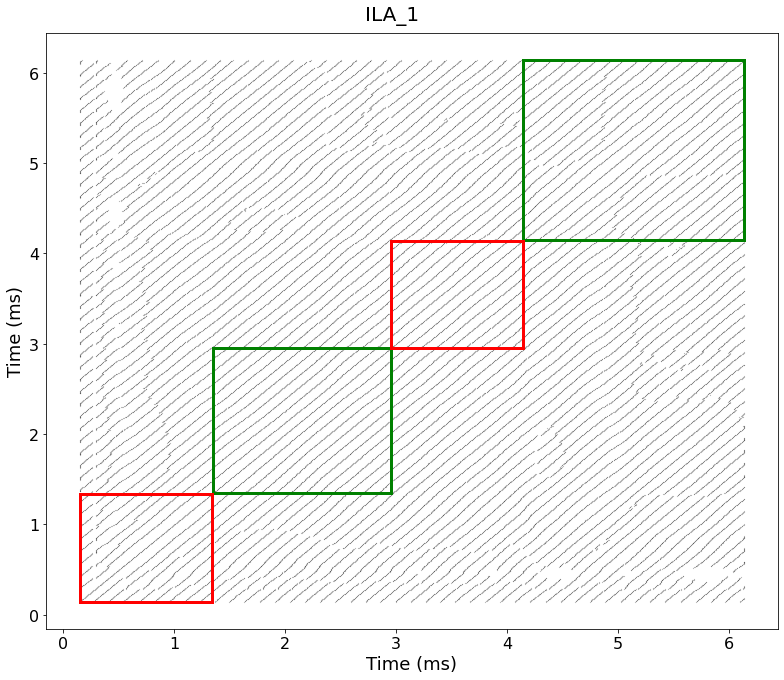

In [18]:
fig,ax = plt.subplots(1,figsize=(11,9.6))
xi,yi = np.where(RPE)
ax.scatter(recurrenceTime[xi],recurrenceTime[yi],s=0.01,color='k')
    
for bId in range(len(blockUpDil)):
    if blockDownIn[bId]-blockUpIn[bId]<=5*meanAFCL*1000//SampleShift: continue
    ax.add_patch(Rectangle((recurrenceTime[blockUpIn[bId]], recurrenceTime[blockUpIn[bId]]),
                            recurrenceTime[blockDownIn[bId]]-recurrenceTime[blockUpIn[bId]],
                           recurrenceTime [blockDownIn[bId]]-recurrenceTime[blockUpIn[bId]],
                            fc='None',ec='g',linewidth=3))                

for bId in range(len(blockUp)):
    if blockDownOut[bId]-blockUpOut[bId]<=5*meanAFCL*1000//SampleShift: continue
    ax.add_patch(Rectangle((recurrenceTime[blockUpOut[bId]],recurrenceTime[ blockUpOut[bId]]),
                            recurrenceTime[blockDownOut[bId]]-recurrenceTime[blockUpOut[bId]], 
                            recurrenceTime[blockDownOut[bId]]-recurrenceTime[blockUpOut[bId]],
                            fc='None',ec='r',linewidth=3))

ax.set_ylabel('Time (ms)',fontsize = 18)
ax.set_xlabel('Time (ms)',fontsize = 18)
ax.tick_params(labelsize=16)
fig.suptitle(cat,fontsize=20)
fig.tight_layout()

print('Recurrence rate of blocks with PSs, in order:')
for bId in RQA_in: print('%0.3f \n'%RQA_in[bId]['recurrence_rate'])
    
print('Recurrence rate of blocks without PSs, in order:')
for bId in RQA_out: print('%0.3f \n'%RQA_out[bId]['recurrence_rate'])


In [28]:
fig,ax = plt.subplots(1,figsize = (11,6))
ax.plot(dilatedBlocksOut,'r',linewidth=2)
ax.plot(dilatedBlocksIn,'g',linewidth=2)
fig.legend(['No PS','PS'])